In [16]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from data_utils import *

In [17]:
data_dir = '../data/'

# load the data
grf_data = np.load(data_dir + 'grf.npy', mmap_mode='r')
muscle_data = np.load(data_dir + 'muscle.npy', mmap_mode='r')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [18]:
data = np.concatenate((grf_data, muscle_data), axis=2)
# print(data.shape)

np.random.seed(42)
np.random.shuffle(data)

In [19]:
num_samples = data.shape[0]
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)

print(f"Number of samples: {num_samples}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

Number of samples: 13388
Train size: 10710
Validation size: 1338


In [20]:
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)


In [21]:
X_train, y_train = train_data[:, :, :3], train_data[:, :, 3:]
X_val, y_val = val_data[:, :, :3], val_data[:, :, 3:]
X_test, y_test = test_data[:, :, :3], test_data[:, :, 3:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

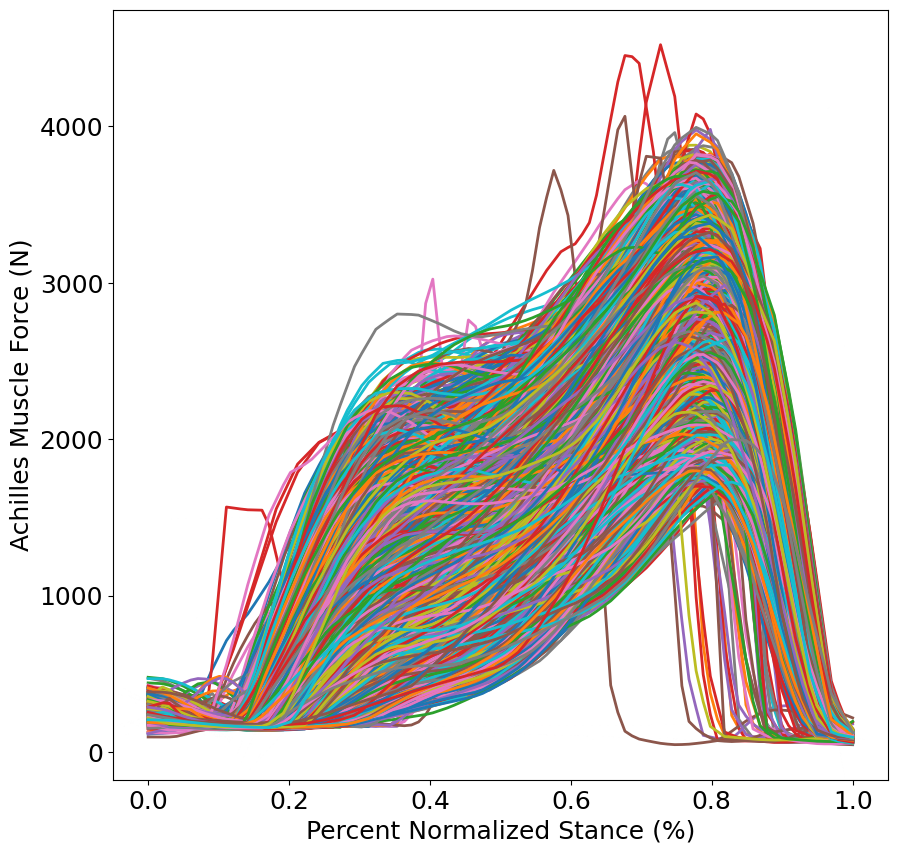

In [22]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance (%)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        
        self.input_embedding = nn.Linear(input_dim, d_model)
        # self.positional_encoding = nn.Parameter(self._generate_positional_encoding(d_model, max_len=100))
        self.register_buffer("positional_encoding", self._generate_positional_encoding(d_model, max_len=100))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        seq_len = x.size(1)
        x = self.input_embedding(x)  # (batch_size, sequence_length, d_model)
        
        x = x + self.positional_encoding[:, :seq_len, :].to(x.device)  # Add positional encoding
        
        x = self.transformer_encoder(x)  # (sequence_length, batch_size, d_model)
        
        output = self.output_layer(x)  # (batch_size, sequence_length, output_dim)
        
        return output

    @staticmethod
    def _generate_positional_encoding(d_model, max_len=100):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log1p(torch.tensor(10000.0)) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # Add batch dimension

In [24]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [25]:
num_epochs = 1000
batch_size = 32

In [26]:
from torch.utils.data import TensorDataset, DataLoader

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
model = TransformerModel(input_dim=3, 
                         output_dim=9, 
                         d_model=64, 
                         nhead=4, 
                         num_encoder_layers=4, 
                         dim_feedforward=128, 
                         dropout=0.1)
model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

In [28]:
# early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

criterion = nn.MSELoss()  # Since the output is continuous muscle force
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()
    
    # initialize training loss
    train_loss = 0
    
    # iterate over the training data
    for X_batch, y_batch in train_loader:
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * X_batch.size(0)
    
    # average training loss over number of samples
    train_loss /= len(train_loader.dataset)
    
    # set model to evaluation mode
    model.eval()
    
    # initialize validation loss
    val_loss = 0
    
    # no need to calculate gradients during validation
    with torch.no_grad():
        # iterate over the validation data
        for X_batch, y_batch in val_loader:
            # forward pass
            outputs = model(X_batch)
            
            # calculate loss
            loss = criterion(outputs, y_batch)
            
            # update validation loss
            val_loss += loss.item() * X_batch.size(0)
    
    # average validation loss over number of samples
    val_loss /= len(val_loader.dataset)
    
    # print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if val_loss < best_val_loss:
        # save best validation loss
        best_val_loss = val_loss
        
        # reset epochs without improvement
        epochs_without_improvement = 0
    else:
        # increment epochs without improvement
        epochs_without_improvement += 1

    # break if patience limit is reached
    if epochs_without_improvement >= patience:
        break

Epoch [10/1000], Train Loss: 253010.7967, Val Loss: 252235.2101
Epoch [20/1000], Train Loss: 228827.9856, Val Loss: 227856.0156
Epoch [30/1000], Train Loss: 200897.7783, Val Loss: 199827.9188
Epoch [40/1000], Train Loss: 171129.3953, Val Loss: 170013.9823
Epoch [50/1000], Train Loss: 140372.5178, Val Loss: 139222.5317
Epoch [60/1000], Train Loss: 109988.3223, Val Loss: 108866.7807
Epoch [70/1000], Train Loss: 81742.5160, Val Loss: 80612.6467
Epoch [80/1000], Train Loss: 57309.6631, Val Loss: 56322.7568
Epoch [90/1000], Train Loss: 37573.8684, Val Loss: 36653.4330
Epoch [100/1000], Train Loss: 23077.1591, Val Loss: 22454.3548
Epoch [110/1000], Train Loss: 13461.7501, Val Loss: 13336.5777
Epoch [120/1000], Train Loss: 7813.6622, Val Loss: 7780.8644
Epoch [130/1000], Train Loss: 4876.8147, Val Loss: 5277.2461
Epoch [140/1000], Train Loss: 3667.9629, Val Loss: 6137.4920
Epoch [150/1000], Train Loss: 3231.7278, Val Loss: 4453.6382


In [29]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
model.eval()

# initialize test loss
test_loss = 0

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 4149.3008


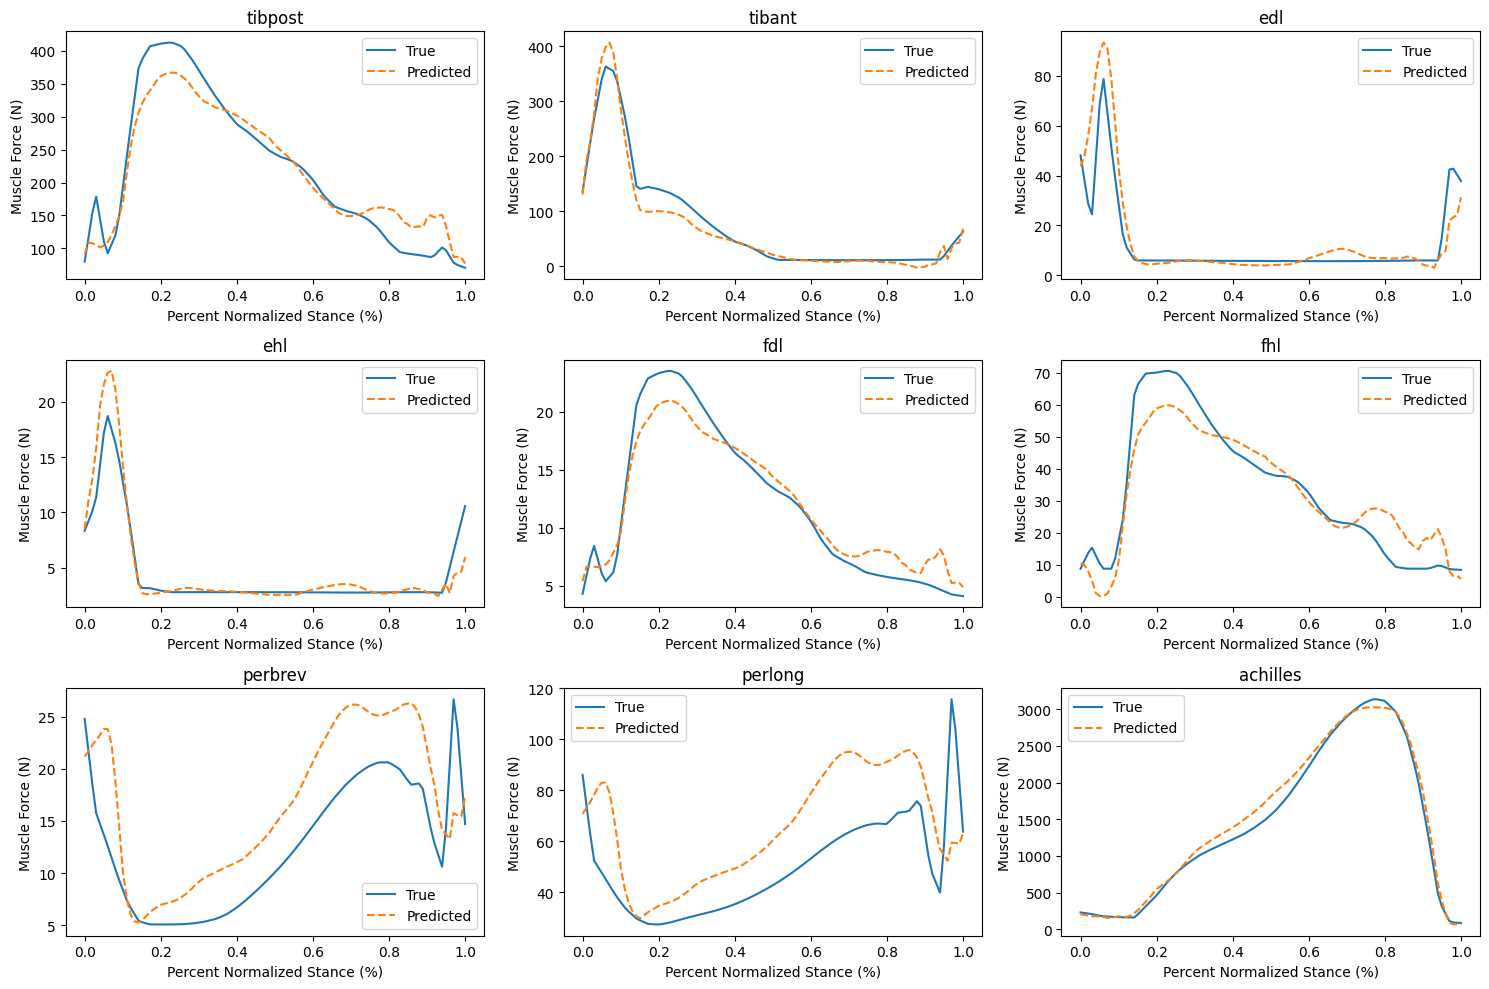

In [30]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()